**References:**
* Official documentation http://surpriselib.com/
* Basic tutorial https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b
* Predicting on Test https://surprise.readthedocs.io/en/stable/FAQ.html#raw-inner-note
* Top N recommendations for each user https://surprise.readthedocs.io/en/stable/FAQ.html?#how-to-get-the-top-n-recommendations-for-each-user
* Making recommendations https://blog.cambridgespark.com/tutorial-practical-introduction-to-recommender-systems-dbe22848392b
* Plotting mean and sd https://stackoverflow.com/questions/22481854/plot-mean-and-standard-deviation

## Loading data and Necessary libraries

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
# Surprise Package
import surprise

In [53]:
# Read data
train_df = pd.read_pickle("../../../train_df_with_valid_recommendations.pkl")
validation_df = pd.read_pickle("../../../validation_df_with_valid_recommendations.pkl")
test_df = pd.read_pickle("../../../test_df_with_valid_recommendations.pkl")

In [54]:
# Explore set shapes
print(train_df.shape)
print(validation_df.shape)

(202990, 22)
(55146, 22)


In [55]:
# Explore train set
train_df.head()

,reviewID,overall,verified,reviewTime,reviewerID,productID,reviewText,summary,vote,style,...,brand,rank,main_cat,description,also_buy,also_view,feature,numberOfReviews,Set,valid_recommendations
473590,473590,5,False,2016-07-16,A2KJVIU82ZUSBA,B0186D1UQ0,Fantastic,Best Remake I've Ever Played,0,{'Format:': ' Video Game'},...,by Atlus,">#4,665 in Video Games (See Top 100 in Video G...",Video Games,"[""ATLUS x Vanillaware, the team behind the hit...","['B077Y7313L', 'B0794Y8FLW', 'B01HQGWBZ2', 'B0...","['B077Y7313L', 'B0794Y8FLW', 'B017GY06UQ', 'B0...","['HD Art Upgrade: Known for its beautiful, 2D ...",26,Train,"[B00007KUUD, B0186D1UQ0, B00004Y57G, B00Z9LUFH..."
128446,128446,5,True,2014-07-18,A3GENOZU8QJZAZ,B000R39GPA,Great game,PS3,0,"{'Edition:': ' Standard', 'Platform:': ' PlayS...",...,by LucasArts,">#9,056 in Video Games (See Top 100 in Video G...",Video Games,['The Star Wars saga will continue in Star War...,"['B0030F1DOO', 'B003FMUMBM', 'B00EY3F8LU', 'B0...","['B01BCMBP44', 'B0030F1DOO', 'B00EY3F8LU', 'B0...",['Confront and associate with familiar faces f...,140,Train,"[B000R39GPA, B00000I1BX, B0012N94WO, B001TOMQS..."
356264,356264,3,True,2015-07-03,ADE6VBLJEOKFC,B00DHF39HQ,Its a game with stuff thats really boring to s...,Buy a car.,2,{'Format:': ' Video Game'},...,by Bethesda,">#5,896 in Video Games (See Top 100 in Video G...",Video Games,"[""The award winning Elder Scrolls saga goes on...","['B01MSDDCUI', 'B07BJ66LRB', 'B01I41HEGY', 'B0...","['B07BJ66LRB', 'B01I41HEGY', 'B01MSDDCUI', 'B0...","['Unlimited Adventures, No Subscription Requir...",135,Train,"[B00USM22DI, B00YQ2KCWO, B00DHF3BZQ, B00LEPDQA..."
396581,396581,5,True,2014-12-25,AGS25M1ED8EGZ,B00K848IH0,love it,great,0,"{'Edition:': ' Alpha Sapphire', 'Platform:': '...",...,by Nintendo,>#837 in Video Games (See Top 100 in Video Gam...,Video Games,"[""Soar high above the Hoenn region on an unfor...","['B0053B66KE', 'B0053B5RGI', 'B071WNTGFY', 'B0...","['B0053B5RGI', 'B00R11EPAC', 'B071JQQ9PK', 'B0...",['Games in 2D. Some areas also playable in 3D....,267,Train,"[B00QLWZWMW, B00846E6X4, B00K848IH0, B005J5K9E..."
244246,244246,4,True,2011-07-15,A1CZT2GDDO4GC1,B003O6G1L4,The main people who are really DOWNING this ga...,"It's not that bad of a game, but does lack a l...",5,"{'Edition:': ' Standard', 'Platform:': ' PlayS...",...,by Square Enix,">#19,535 in Video Games (See Top 100 in Video ...",Video Games,"[""Torn asunder, the delicate balance of power ...","['B00IQCRO3K', 'B001BTPRKC', 'B000HCJD68', 'B0...","['B00IQCRO3K', 'B007V9QKH0', 'B00B59MXGY', 'B0...","['For the first time, play DUNGEON SIEGE on hi...",43,Train,"[B003O6G1L4, B00IQCRO3K, B001BTPRKC, B000HCJD6..."


In [56]:
# Possible values for ratings
pd.concat([train_df, validation_df])["overall"].value_counts()

5    151416
4     50922
3     27682
1     15074
2     13042
Name: overall, dtype: int64

In [57]:
ratings_summary = pd.DataFrame(pd.concat([train_df, validation_df]).groupby(["overall"]).count()["productID"]).reset_index()
ratings_summary.columns = ["Rating", "Count"]
ratings_summary

,Rating,Count
0,1,15074
1,2,13042
2,3,27682
3,4,50922
4,5,151416


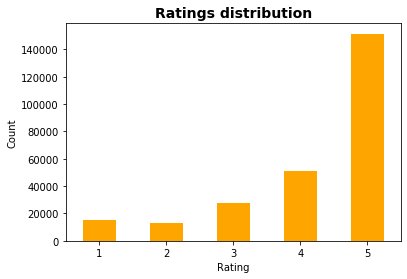

In [58]:
ax = ratings_summary.plot(x = "Rating", y = "Count", kind = "bar", color = "orange", legend = False, figsize = (6, 4))
plt.xticks(rotation=0)
plt.ylabel("Count")
#ax.set_ylabel(ylabel = "Count", position=(0,1), fontsize = 12)
plt.title("Ratings distribution", fontweight = "bold", fontsize = 14)
plt.show()

## Fitting the model on Train set

### Loading data into Surprise

In [8]:
# Instantiate reader object, to parse ratings
reader = surprise.Reader(rating_scale=(1, 5))

In [9]:
# Load Train data into Surprise, from train_df and using reader instantiated above
surprise_data_train = surprise.Dataset.load_from_df(train_df[['reviewerID', 'productID', 'overall']], reader)

### Training the model

In [10]:
# Define parameter grid
param_grid = {"n_factors": [10, 20, 30, 40, 50],
              "n_epochs": [25, 50, 75]}

In [11]:
# Instantiate grid search CV
grid_search = surprise.model_selection.GridSearchCV(algo_class = surprise.NMF, 
                                                    param_grid = param_grid, 
                                                    measures=['rmse'], 
                                                    cv = 5, 
                                                    n_jobs = 7)

In [12]:
# Look for best parameters on train data
grid_search.fit(surprise_data_train)

In [13]:
# Best RMSE score (prediction of what Test RMSE will be)
print(grid_search.best_score['rmse'])

1.150953934906876


In [14]:
# Combination of parameters that gave the best RMSE score
print(grid_search.best_params['rmse'])

{'n_factors': 40, 'n_epochs': 50}


In [15]:
# Get model with best performance
best_NMF = grid_search.best_estimator['rmse']

### Predicting ratings

In [16]:
# Fit best NMF on Train
best_NMF.fit(surprise_data_train.build_full_trainset())

In [17]:
predictions_train = best_NMF.test(surprise_data_train.build_full_trainset().build_testset())
surprise.accuracy.rmse(predictions_train)

RMSE: 0.3794


0.37936171380788886

## Getting Top K recommendations for each row in Train

In [59]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        
        top_n[uid] = user_ratings[:n]

    #
    for key in top_n.keys():
        top_n[key] = [x[0] for x in top_n[key]]
        #print(type(top_n[key]))       
    
    return top_n

In [60]:
# Calculate top K recommended products
train_df["top_1_recommended"] = train_df["reviewerID"].map(get_top_n(predictions_train, 1))
train_df["top_3_recommended"] = train_df["reviewerID"].map(get_top_n(predictions_train, 3))
train_df["top_5_recommended"] = train_df["reviewerID"].map(get_top_n(predictions_train, 5))
train_df["top_10_recommended"] = train_df["reviewerID"].map(get_top_n(predictions_train, 10))
train_df["top_15_recommended"] = train_df["reviewerID"].map(get_top_n(predictions_train, 15))

## Calculating Accuracy in Train

In [61]:
# Calculate accuracy @ 1
train_df["accuracy_at_1"] = 0
for index, row in train_df.iterrows():
    train_df.loc[index, "accuracy_at_1"] = len(set(row["top_1_recommended"]).intersection(set(row["valid_recommendations"][:1])))/1

# Calculate accuracy @ 3
train_df["accuracy_at_3"] = 0
for index, row in train_df.iterrows():
    train_df.loc[index, "accuracy_at_3"] = len(set(row["top_3_recommended"]).intersection(set(row["valid_recommendations"][:3])))/3

# Calculate accuracy @ 5
train_df["accuracy_at_5"] = 0
for index, row in train_df.iterrows():
    train_df.loc[index, "accuracy_at_5"] = len(set(row["top_5_recommended"]).intersection(set(row["valid_recommendations"][:5])))/5

# Calculate accuracy @ 10
train_df["accuracy_at_10"] = 0
for index, row in train_df.iterrows():
    train_df.loc[index, "accuracy_at_10"] = len(set(row["top_10_recommended"]).intersection(set(row["valid_recommendations"][:10])))/10

# Calculate accuracy @ 15
train_df["accuracy_at_15"] = 0
for index, row in train_df.iterrows():
    train_df.loc[index, "accuracy_at_15"] = len(set(row["top_15_recommended"]).intersection(set(row["valid_recommendations"][:15])))/15

In [62]:
# Get means for accuracy at K
print(np.mean(train_df["accuracy_at_1"]))
print(np.mean(train_df["accuracy_at_3"]))
print(np.mean(train_df["accuracy_at_5"]))
print(np.mean(train_df["accuracy_at_10"]))
print(np.mean(train_df["accuracy_at_15"]))

0.5149219173358294
0.6453257139106262
0.5986876200800959
0.4450839942854294
0.3498799612459237


In [63]:
MAP_train = np.mean([np.mean(train_df["accuracy_at_1"]), 
                     np.mean(train_df["accuracy_at_3"]), 
                     np.mean(train_df["accuracy_at_5"]),
                     np.mean(train_df["accuracy_at_10"]),
                     np.mean(train_df["accuracy_at_15"])])

In [64]:
MAP_train

0.510779841371581

## Predicting on Validation Set

In [65]:
validation_list = []

In [66]:
for _, row in validation_df.iterrows():
    t = (row["reviewerID"], row["productID"], row["overall"])
    validation_list.append(t)

In [67]:
# Predict using best model found
validation_predictions = best_NMF.test(validation_list)

In [68]:
# Compute Test RMSE
surprise.accuracy.rmse(validation_predictions)

RMSE: 1.1229


1.1228819749813392

## Getting Top K recommendations for each row in Validation

In [71]:
# Calculate top K recommended products
validation_df["top_1_recommended"] = validation_df["reviewerID"].map(get_top_n(validation_predictions, 1))
validation_df["top_3_recommended"] = validation_df["reviewerID"].map(get_top_n(validation_predictions, 3))
validation_df["top_5_recommended"] = validation_df["reviewerID"].map(get_top_n(validation_predictions, 5))
validation_df["top_10_recommended"] = validation_df["reviewerID"].map(get_top_n(validation_predictions, 10))
validation_df["top_15_recommended"] = validation_df["reviewerID"].map(get_top_n(validation_predictions, 15))

## Calculating accuracy in Validation

In [72]:
# Calculate accuracy @ 1
validation_df["accuracy_at_1"] = 0
for index, row in validation_df.iterrows():
    validation_df.loc[index, "accuracy_at_1"] = len(set(row["top_1_recommended"]).intersection(set(row["valid_recommendations"][:1])))/1

# Calculate accuracy @ 3
validation_df["accuracy_at_3"] = 0
for index, row in validation_df.iterrows():
    validation_df.loc[index, "accuracy_at_3"] = len(set(row["top_3_recommended"]).intersection(set(row["valid_recommendations"][:3])))/3

# Calculate accuracy @ 5
validation_df["accuracy_at_5"] = 0
for index, row in validation_df.iterrows():
    validation_df.loc[index, "accuracy_at_5"] = len(set(row["top_5_recommended"]).intersection(set(row["valid_recommendations"][:5])))/5

# Calculate accuracy @ 10
validation_df["accuracy_at_10"] = 0
for index, row in validation_df.iterrows():
    validation_df.loc[index, "accuracy_at_10"] = len(set(row["top_10_recommended"]).intersection(set(row["valid_recommendations"][:10])))/10

# Calculate accuracy @ 15
validation_df["accuracy_at_15"] = 0
for index, row in validation_df.iterrows():
    validation_df.loc[index, "accuracy_at_15"] = len(set(row["top_15_recommended"]).intersection(set(row["valid_recommendations"][:15])))/15

In [73]:
# Get means for accuracy at K
print(np.mean(validation_df["accuracy_at_1"]))
print(np.mean(validation_df["accuracy_at_3"]))
print(np.mean(validation_df["accuracy_at_5"]))
print(np.mean(validation_df["accuracy_at_10"]))
print(np.mean(validation_df["accuracy_at_15"]))

0.1255757443876256
0.23159733555777529
0.22673992673995677
0.16932869111092258
0.1326587603814669


In [74]:
MAP_validation = np.mean([np.mean(validation_df["accuracy_at_1"]), 
                     np.mean(validation_df["accuracy_at_3"]), 
                     np.mean(validation_df["accuracy_at_5"]),
                     np.mean(validation_df["accuracy_at_10"]),
                     np.mean(validation_df["accuracy_at_15"])])

In [75]:
MAP_validation

0.1771800916355494

## Plotting results

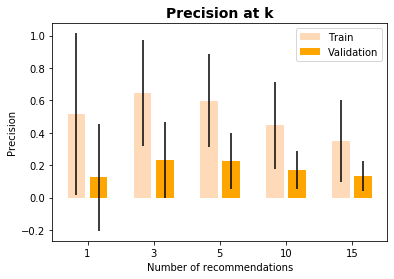

In [76]:
# 5 values for K
x_train = [1, 4, 7, 10, 13]
x_val = [2, 5, 8, 11, 14]


# Training means
y_train = [np.mean(train_df["accuracy_at_1"]),
         np.mean(train_df["accuracy_at_3"]),
         np.mean(train_df["accuracy_at_5"]),
         np.mean(train_df["accuracy_at_10"]),
         np.mean(train_df["accuracy_at_15"])]

# Training stds
error_train = [np.std(train_df["accuracy_at_1"]),
             np.std(train_df["accuracy_at_3"]),
             np.std(train_df["accuracy_at_5"]),
             np.std(train_df["accuracy_at_10"]),
             np.std(train_df["accuracy_at_15"])]

# Validation means
y_val = [np.mean(validation_df["accuracy_at_1"]),
         np.mean(validation_df["accuracy_at_3"]),
         np.mean(validation_df["accuracy_at_5"]),
         np.mean(validation_df["accuracy_at_10"]),
         np.mean(validation_df["accuracy_at_15"])]

# Validation stds
error_val = [np.std(validation_df["accuracy_at_1"]),
             np.std(validation_df["accuracy_at_3"]),
             np.std(validation_df["accuracy_at_5"]),
             np.std(validation_df["accuracy_at_10"]),
             np.std(validation_df["accuracy_at_15"])]

# Plot errorbars
plt.bar(x = x_train, height = y_train, yerr = error_train, color = "peachpuff", label = "Train")
plt.bar(x = x_val, height = y_val, yerr = error_val, color = "orange", label = "Validation")

# Titles and axis labels
plt.title("Precision at k", fontweight = "bold", fontsize = 14)
plt.xlabel("Number of recommendations")
plt.ylabel("Precision")
plt.xticks(ticks = [1.5, 4.5, 7.5, 10.5, 13.5], labels = [1, 3, 5, 10, 15])

# Add legend
plt.legend()

# Show plot
plt.show()

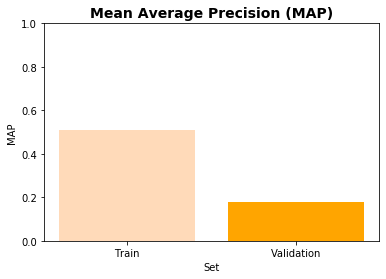

In [77]:
# Plot MAP
plt.bar(x = 1, height = MAP_train, color = "peachpuff", label = "Train")
plt.bar(x = 2, height = MAP_validation, color = "orange", label = "Validation")

# Titles and axis labels
plt.title("Mean Average Precision (MAP)", fontweight = "bold", fontsize = 14)
plt.xlabel("Set")
plt.ylabel("MAP")
plt.ylim((0, 1))
plt.xticks(ticks = [1, 2], labels = ["Train", "Validation"])

# Show plot
plt.show()

## Predicting on Test Set

In [78]:
test_list = []

In [79]:
for _, row in test_df.iterrows():
    t = (row["reviewerID"], row["productID"], row["overall"])
    test_list.append(t)

In [80]:
# Predict using best model found
test_predictions = best_NMF.test(test_list)

In [81]:
# Compute Test RMSE
surprise.accuracy.rmse(test_predictions)

RMSE: 1.1280


1.128023704651588

## Getting Top K recommendations for each row in Test

In [82]:
# Calculate top K recommended products
test_df["top_1_recommended"] = test_df["reviewerID"].map(get_top_n(test_predictions, 1))
test_df["top_3_recommended"] = test_df["reviewerID"].map(get_top_n(test_predictions, 3))
test_df["top_5_recommended"] = test_df["reviewerID"].map(get_top_n(test_predictions, 5))
test_df["top_10_recommended"] = test_df["reviewerID"].map(get_top_n(test_predictions, 10))
test_df["top_15_recommended"] = test_df["reviewerID"].map(get_top_n(test_predictions, 15))

## Calculating Accuracy on Test

In [83]:
# Calculate accuracy @ 1
test_df["accuracy_at_1"] = 0
for index, row in test_df.iterrows():
    test_df.loc[index, "accuracy_at_1"] = len(set(row["top_1_recommended"]).intersection(set(row["valid_recommendations"][:1])))/1

# Calculate accuracy @ 3
test_df["accuracy_at_3"] = 0
for index, row in test_df.iterrows():
    test_df.loc[index, "accuracy_at_3"] = len(set(row["top_3_recommended"]).intersection(set(row["valid_recommendations"][:3])))/3

# Calculate accuracy @ 5
test_df["accuracy_at_5"] = 0
for index, row in test_df.iterrows():
    test_df.loc[index, "accuracy_at_5"] = len(set(row["top_5_recommended"]).intersection(set(row["valid_recommendations"][:5])))/5

# Calculate accuracy @ 10
test_df["accuracy_at_10"] = 0
for index, row in test_df.iterrows():
    test_df.loc[index, "accuracy_at_10"] = len(set(row["top_10_recommended"]).intersection(set(row["valid_recommendations"][:10])))/10

# Calculate accuracy @ 15
test_df["accuracy_at_15"] = 0
for index, row in test_df.iterrows():
    test_df.loc[index, "accuracy_at_15"] = len(set(row["top_15_recommended"]).intersection(set(row["valid_recommendations"][:15])))/15

In [84]:
# Get means for accuracy at K
print(np.mean(test_df["accuracy_at_1"]))
print(np.mean(test_df["accuracy_at_3"]))
print(np.mean(test_df["accuracy_at_5"]))
print(np.mean(test_df["accuracy_at_10"]))
print(np.mean(test_df["accuracy_at_15"]))

0.10954570535221629
0.168965728649385
0.1600441419900319
0.11508920360489387
0.08826926613940927


In [85]:
MAP_test = np.mean([np.mean(test_df["accuracy_at_1"]), 
                     np.mean(test_df["accuracy_at_3"]), 
                     np.mean(test_df["accuracy_at_5"]),
                     np.mean(test_df["accuracy_at_10"]),
                     np.mean(test_df["accuracy_at_15"])])

In [86]:
MAP_test

0.12838280914718725

## Plotting results

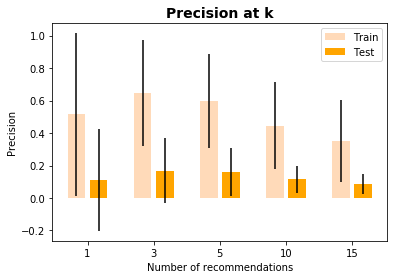

In [87]:
# 5 values for K
x_train = [1, 4, 7, 10, 13]
x_test = [2, 5, 8, 11, 14]


# Training means
y_train = [np.mean(train_df["accuracy_at_1"]),
         np.mean(train_df["accuracy_at_3"]),
         np.mean(train_df["accuracy_at_5"]),
         np.mean(train_df["accuracy_at_10"]),
         np.mean(train_df["accuracy_at_15"])]

# Training stds
error_train = [np.std(train_df["accuracy_at_1"]),
             np.std(train_df["accuracy_at_3"]),
             np.std(train_df["accuracy_at_5"]),
             np.std(train_df["accuracy_at_10"]),
             np.std(train_df["accuracy_at_15"])]

# Validation means
y_test = [np.mean(test_df["accuracy_at_1"]),
         np.mean(test_df["accuracy_at_3"]),
         np.mean(test_df["accuracy_at_5"]),
         np.mean(test_df["accuracy_at_10"]),
         np.mean(test_df["accuracy_at_15"])]

# Validation stds
error_test = [np.std(test_df["accuracy_at_1"]),
             np.std(test_df["accuracy_at_3"]),
             np.std(test_df["accuracy_at_5"]),
             np.std(test_df["accuracy_at_10"]),
             np.std(test_df["accuracy_at_15"])]

# Plot errorbars
plt.bar(x = x_train, height = y_train, yerr = error_train, color = "peachpuff", label = "Train")
plt.bar(x = x_test, height = y_test, yerr = error_test, color = "orange", label = "Test")

# Titles and axis labels
plt.title("Precision at k", fontweight = "bold", fontsize = 14)
plt.xlabel("Number of recommendations")
plt.ylabel("Precision")
plt.xticks(ticks = [1.5, 4.5, 7.5, 10.5, 13.5], labels = [1, 3, 5, 10, 15])

# Add legend
plt.legend()

# Show plot
plt.show()

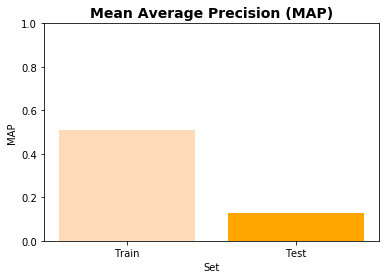

In [88]:
# Plot MAP
plt.bar(x = 1, height = MAP_train, color = "peachpuff", label = "Train")
plt.bar(x = 2, height = MAP_test, color = "orange", label = "Test")

# Titles and axis labels
plt.title("Mean Average Precision (MAP)", fontweight = "bold", fontsize = 14)
plt.xlabel("Set")
plt.ylabel("MAP")
plt.ylim((0, 1))
plt.xticks(ticks = [1, 2], labels = ["Train", "Test"])

# Show plot
plt.show()